based on: https://github.com/essentialsofparallelcomputing/Chapter3/blob/master/JupyterNotebook/HardwarePlatformCharaterization.ipynb

## Operator Benchmark on Gauss3

### Theoretical Parameters

In [37]:
Sockets=2
ProcessorFrequency=2.35
ProcessorCores=64
Hyperthreads=2
VectorWidth=256
WordSizeBits=64
FMA=2

In [38]:
DataTransferRate=3200
MemoryChannels=8
BytesTransferredPerAccess=8

In [39]:
TheoreticalMaximumFlops=Sockets*ProcessorCores*Hyperthreads*ProcessorFrequency*VectorWidth/WordSizeBits*FMA
TheoreticalMemoryBandwidth=Sockets*DataTransferRate*MemoryChannels*BytesTransferredPerAccess/1000
TheoreticalMachineBalance=TheoreticalMaximumFlops/TheoreticalMemoryBandwidth

### Empirically Determined Parameters

based on `src_master_thesis/node_characterization/likwid-bench_gauss3.out`:

In [40]:
emp_flops_max=2459.32383
emp_mem_band=233.172

### Benchmark data

#### Previous Versions

In [41]:

FLOPS_apply = [
    1.0653186,
    4.1038111,
    5.1812428,
    4.2049185,
    233.9369645,
    72.5927764
]
AI_apply = [
    0.0296,
    0.0884,
    0.1145,
    0.1199455409875806,
    1.61640489219573,
    0.3220851675084072
]
labels_apply = [
    "00_stencil_unoptimized",
    "01_stencil_compiler_optimized",
    "03_stencil_vcl_vectorization",
    "04_stencil_tiling",
    "05_openmp_stencil_para",
    "06_openmp_stencil_01_firsttouch"
]

#### Current Versions

In [42]:
import csv

def read_Results(p_path):
    with open(p_path, 'r') as f:
        reader = csv.reader(f)
        #
        # NOTE skip the header
        #
        next(reader, None)
        for row in reader:
            #
            # NOTE select row
            #
            if row[3] == 'apply':
                performance = float(row[8])
                memory_bandwidth = float(row[9])
                break
    result = {
        #
        # NOTE MFLOP/s => GFLOP/s
        #
        'flops': performance/1000,
        'ai': performance/memory_bandwidth
    }
    return result

In [43]:

results = read_Results('./e_linear_stencil_noedgecases_likwid_roofline_gauss3.csv')

print(results)

FLOPS_apply.append(results['flops'])
AI_apply.append(results['ai'])
labels_apply.append('08_openmp_stencil_03_noedgecases')

{'flops': 98.04469560000001, 'ai': 0.42690517018704194}


### Roofline Model

In [44]:
# roofline_flops=TheoreticalMaximumFlops
# roofline_mem_band=TheoreticalMemoryBandwidth

roofline_flops=emp_flops_max
roofline_mem_band=emp_mem_band
roofline_ma_bal=roofline_flops/roofline_mem_band

('#17becf', '#dbdb8d', '#bcbd22', '#c7c7c7', '#7f7f7f', '#f7b6d2', '#e377c2', '#c49c94', '#8c564b', '#c5b0d5', '#9467bd', '#ff9896', '#d62728', '#98df8a', '#2ca02c', '#ffbb78', '#ff7f0e', '#aec7e8', '#1f77b4')


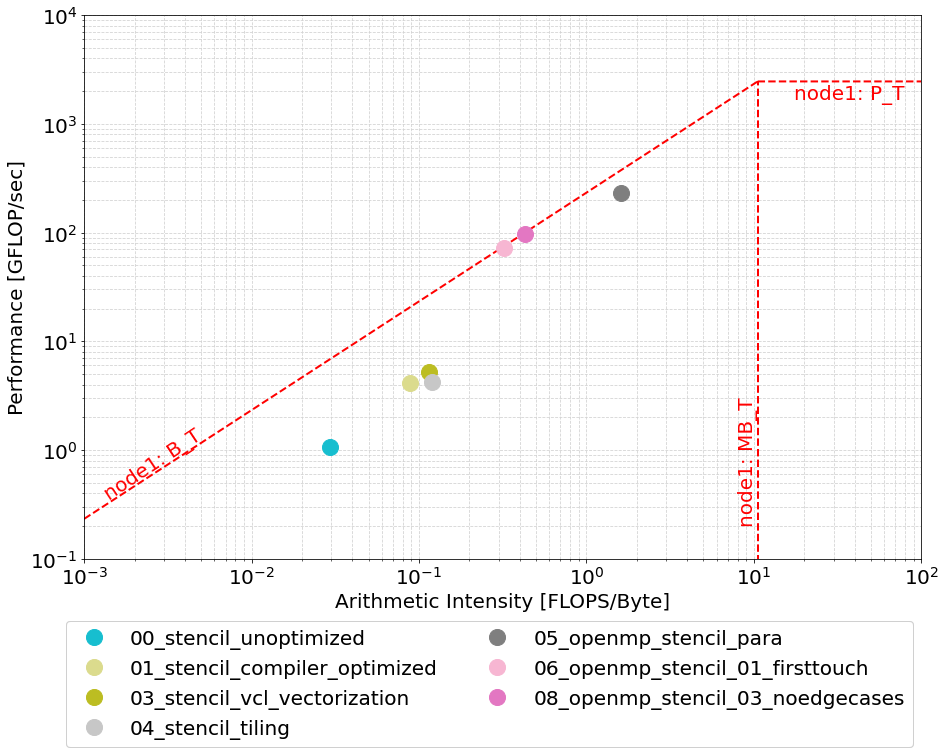

In [46]:
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install numpy

# %matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

font = { 'size'   : 20}
plt.rc('font', **font)

markersize = 16

#
# NOTE: color scheme 'Tableau 20'
# source: https://help.tableau.com/current/pro/desktop/de-de/formatting_create_custom_colors.htm
#
colors = (
    '#17becf',
    '#dbdb8d',
    '#bcbd22',
    '#c7c7c7',
    '#7f7f7f',
    '#f7b6d2',
    '#e377c2',
    '#c49c94',
    '#8c564b',
    '#c5b0d5',
    '#9467bd',
    '#ff9896',
    '#d62728',
    '#98df8a',
    '#2ca02c',
    '#ffbb78',
    '#ff7f0e',
    '#aec7e8',
    '#1f77b4'
)

print(colors)
styles = ['o','s','v','^','D',">","<","*","h","H","+","1","2","3","4","8","p","d","|","_",".",","]

roofline_color = 'r'

fig = plt.figure(1,figsize=(15,10))
plt.clf()
ax = fig.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Arithmetic Intensity [FLOPS/Byte]')
ax.set_ylabel('Performance [GFLOP/sec]')
ax.grid()
ax.grid(True,which="both",linestyle="--",color='lightgray') 

nx = 10000
xmin = -3
xmax = 2
ymin = 0.1
ymax = 10000

ax.set_xlim(10**xmin, 10**xmax)
ax.set_ylim(ymin, ymax)

ixx = int(nx*0.02)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

scomp_x_elbow = [] 
scomp_ix_elbow = [] 
smem_x_elbow = [] 
smem_ix_elbow = [] 

x = np.logspace(xmin,xmax,nx)

#
# rooflines
#
for ix in range(1,nx):
    if roofline_mem_band * x[ix] >= roofline_flops and roofline_mem_band * x[ix-1] < roofline_flops:
        theoMem_ix_elbow = ix-1
        break
for ix in range(1,nx):
    if (roofline_flops <= roofline_mem_band * x[ix] and roofline_flops > roofline_mem_band * x[ix-1]):
        theoFlops_ix_elbow = ix-1
        break
y = np.ones(len(x)) * roofline_flops
ax.plot(x[theoFlops_ix_elbow:],y[theoFlops_ix_elbow:],c=roofline_color,ls='--',lw='2')
ax.text(x[-ixx],roofline_flops*0.95,
    'node1: P_T',
    horizontalalignment='right',
    verticalalignment='top',
    c=roofline_color)
y = x * roofline_mem_band  
ax.plot(x[:theoMem_ix_elbow+1],y[:theoMem_ix_elbow+1],c=roofline_color,ls='--',lw='2')
ang = np.arctan(np.log10(xlim[1]/xlim[0]) / np.log10(ylim[1]/ylim[0]) 
    * fig.get_size_inches()[1]/fig.get_size_inches()[0] )
ax.text(x[ixx],x[ixx]*roofline_mem_band*(1+0.25*np.sin(ang)**2),
    'node1: B_T',
    horizontalalignment='left',
    verticalalignment='bottom',
    rotation=180/np.pi*ang,
    c=roofline_color)
plt.vlines(roofline_ma_bal, 0, roofline_flops, colors=roofline_color, linestyles='dashed', linewidth=2)
ax.text(roofline_ma_bal,2*ymin,
    'node1: MB_T',
    horizontalalignment='right',
    verticalalignment='bottom',
    rotation=90,
    c=roofline_color)

marker_handles = list()
for i in range(0,len(AI_apply)):
  ax.plot(float(AI_apply[i]),float(FLOPS_apply[i]),c=colors[i],marker=styles[0],linestyle='None',ms=markersize,label=labels_apply[i])
  marker_handles.append(ax.plot([],[],c=colors[i],marker=styles[0],linestyle='None',ms=markersize,label=labels_apply[i])[0]) 

#
# NOTE: put legend out of the plot: https://stackoverflow.com/a/43439132
#
leg1 = plt.legend(handles = marker_handles,
                  ncol=2,
                  bbox_to_anchor=(0.5,-0.15),
                  bbox_transform=fig.transFigure,
                  loc="lower center")
ax.add_artist(leg1)

# plt.savefig('roofline.png')
# plt.savefig('roofline.eps')
# plt.savefig('roofline.pdf')
# plt.savefig('roofline.svg')

plt.show()